# Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.signal as signal
import sklearn.metrics
from scipy import stats
from scipy.stats import skew, kurtosis
from sklearn import tree
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import LearningCurveDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from typing import Any
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA


from Classifiers.TestRunner import fit_classifier

# Variable settings

In [3]:
# Outlier detection settings
OUTLIERS_DETECTORS = ["IsolationForest", "ZScore"]
DETECTOR = "IsolationForest"
REMOVE_OUTLIERS = True

# Classifier settings
models = {
    DecisionTreeClassifier() : {
        'max_depth': [3, 5, 10],
        'min_samples_split': [2, 5, 10],
        'criterion': ['gini', 'entropy']},
    SVC() : {
        'kernel': ['rbf', 'poly', 'sigmoid'],
        'C': [1e-1, 1e-2, 1e-3, 1e-4],
        'gamma': [1e-1, 1e-2, 1e-3, 1e-4],
    },
    RandomForestClassifier() : {
        'n_estimators': [10, 20, 30, 40, 50],
        'criterion': ['gini', 'entropy'],
        'max_depth': [3, 5, 10],
        'max_features': ['sqrt'],
        'min_samples_split': [2, 5, 10],
        'bootstrap': [True, False]
    }}

# Function to detect outliers using Isolation Forest

In [4]:
def outlier_detection_isolation_forest(X: np.ndarray, y:np.ndarray, outlier_class: int = -1) -> np.ndarray:
    isolation_forest = IsolationForest(contamination=0.05)
    res = isolation_forest.fit_predict(X=X)

    # Identify outlier indices
    if outlier_class == -1:
        isolation_forest_outlier_indices = np.where(np.array(res == -1))[0]
    else:
        isolation_forest_outlier_indices = np.where(np.array(res == -1) & (y == outlier_class))[0]

    return isolation_forest_outlier_indices

# Function to detect outliers using Z-score method

In [5]:
# Function to detect outliers using Z-score method
def outlier_detection_Z_score(X: np.ndarray, y: np.ndarray, outlier_class: int = -1) -> np.ndarray:
    threshold = 3 # Z-score threshold for identifying outliers
    drop_threshold = 100 # Minimum count of outlier dimensions for a sample to be removed

    z_scores = np.abs(stats.zscore(X))
    z_score_count = np.sum(z_scores > threshold, axis=1)
    res = np.where(z_score_count > drop_threshold, [-1]*z_scores.shape[0], 1)

    if outlier_class == -1:
        z_score_outliers_indices = np.where(np.array(res == -1))[0]
    else:
        z_score_outliers_indices = np.where(np.array(res == -1) & (y == outlier_class))[0]

    return z_score_outliers_indices

# Function to separate data into training and external test sets

In [6]:
# Function to separate data into training and external test sets
def data_separation(df: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    df_clean = df[df.y.isin((3, 4))]
    df_clean.reset_index(drop=True, inplace=True)

    # Randomly select 20% of each class for external testing
    rng = np.random.default_rng()
    random_index = rng.choice(df_clean[df_clean.y == 3].index, size=int(len(df_clean[df_clean.y == 3]) * 0.2), replace=False)
    random_index = np.concatenate((random_index, rng.choice(df_clean[df_clean.y == 4].index,
                                                            size=int(len(df_clean[df_clean.y == 4]) * 0.2),
                                                            replace=False)))

    external_test_df = df_clean.iloc[random_index]
    df_clean = df_clean.drop(random_index)
    df_clean.reset_index(drop=True, inplace=True)

    return df_clean, external_test_df

# Function to normalize data using StandardScaler

In [7]:
# Function to normalize data using StandardScaler
def data_scaling(df: pd.DataFrame) -> tuple[np.ndarray, np.ndarray]:
    scaler3 = StandardScaler()
    X_3 = scaler3.fit_transform(df[df.y == 3].iloc[:, 1:].to_numpy())
    scaler4 = StandardScaler()
    X_4 = scaler4.fit_transform(df[df.y == 4].iloc[:, 1:].to_numpy())

    X_3[:, -1] = 3
    X_4[:, -1] = 4

    normalized_df = np.concatenate([X_3, X_4], axis=0)
    np.random.shuffle(normalized_df)
    X = normalized_df[:, :-1]
    y = normalized_df[:, -1]

    return X, y

def data_scaling_ext(df: pd.DataFrame) -> tuple[np.ndarray, np.ndarray]:
    scaler = StandardScaler()
    X = scaler.fit_transform(df.iloc[:, 1:-1])
    y = df.iloc[:, -1]

    return X, y

# Function to extract time-domain features from EEG data

In [8]:
# Function to extract time-domain features from EEG data
def time_domain_features(eeg_signal):
    features = {
        "mean": np.mean(eeg_signal),
        "variance": np.var(eeg_signal),
        "skewness": skew(eeg_signal),
        "kurtosis": kurtosis(eeg_signal),
        "rms": np.sqrt(np.mean(eeg_signal**2)),
        "zero_crossings": np.sum(np.diff(np.sign(eeg_signal)) != 0),
    }

    features["norm_zero_crossing"] = (features["zero_crossings"] - features["mean"]) / (features["rms"] + 1e-6)

    return features

# Function for signal processing

In [ ]:
# Function to preprocess EEG signals with filtering and feature extraction
def signal_processing(row):
    fs = 250  # Sampling frequency (Hz)

    # Low-pass filter (FIR filter design)
    kernel = signal.firwin(51, cutoff=30, fs=fs)  # 30 Hz cutoff
    filtered_signal = np.convolve(row[:400], kernel, mode='valid')
    features = time_domain_features(filtered_signal)
    filtered_signal = (filtered_signal - features["mean"]) / np.sqrt(features["variance"])
    features = time_domain_features(filtered_signal)

    row = np.append(filtered_signal, features["norm_zero_crossing"])

    return row


# Training and external test

In [10]:
def train_models(targets, X, y):
    best_models = {}
    for model, params in targets.items():
        best_model, best_params = fit_classifier(model, X, y, param_grid=params)
        best_models[model.__class__.__name__] = best_model

    return best_models

def run_external_test(models, X, y_true):
    results = {}
    for model_name, model in models.items():
        y_pred = model.predict(X)
        accuracy = sklearn.metrics.accuracy_score(y_true, y_pred)
        sensitivity = sklearn.metrics.recall_score(y_true, y_pred, pos_label=4)
        specificity = sklearn.metrics.recall_score(y_true, y_pred, pos_label=3)
        matrix = confusion_matrix(y_true, y_pred, normalize='true')
        results[model_name] = {"accuracy": accuracy, "sensitivity": sensitivity, "specificity": specificity, "confusion_matrix": matrix}

    return results

# Running test function

In [11]:
scorers = {
    'accuracy': sklearn.metrics.make_scorer(sklearn.metrics.accuracy_score),
    'sensitivity': sklearn.metrics.make_scorer(sklearn.metrics.recall_score, pos_label=4),
    'specificity': sklearn.metrics.make_scorer(sklearn.metrics.recall_score, pos_label=3)
}

def fit_classifier(classifier, x, y, param_grid, cv=5, scoring='accuracy') -> tuple[Any, Any]:
    grid_search = GridSearchCV(estimator=classifier,
                               param_grid=param_grid,
                               cv=cv,
                               scoring=scoring)

    grid_search.fit(x, y)
    return grid_search.best_estimator_, grid_search.best_params_


____

# Data loading

In [12]:
df = pd.read_csv('EEG-data - EEG-data.csv')
df.info()

df_clean, external_test_df = data_separation(df)
X, y = data_scaling(df_clean)

if REMOVE_OUTLIERS:
    if DETECTOR == "IsolationForest":
        outliers_indices = outlier_detection_isolation_forest(X, y)
    else:
        outliers_indices = outlier_detection_Z_score(X, y)

    X = np.delete(X, outliers_indices, axis=0)
    y = np.delete(y, outliers_indices)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Columns: 4096 entries, Unnamed: 0 to y
dtypes: int64(4096)
memory usage: 15.6 MB


# Plotting the first patients of class 3 and 4

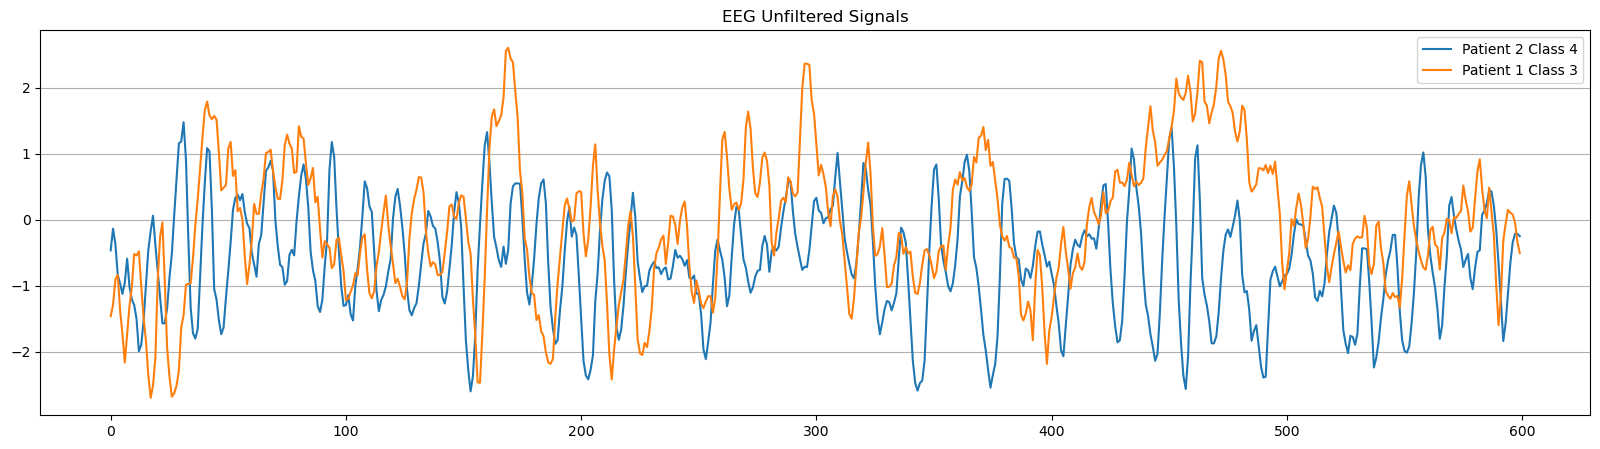

In [13]:
# Plotting the unfiltered signals for the first sample of each class
plt.figure(figsize=(20, 5))
plt.plot(X[y == 4][0, : 600], label="Patient 2 Class 4")
plt.plot(X[y == 3][0, : 600], label="Patient 1 Class 3")
plt.title("EEG Unfiltered Signals")
plt.grid(axis='y')
plt.legend()
plt.show()

In [14]:
# Filtered and extended dataset
extended_x = np.apply_along_axis(signal_processing,1, X)

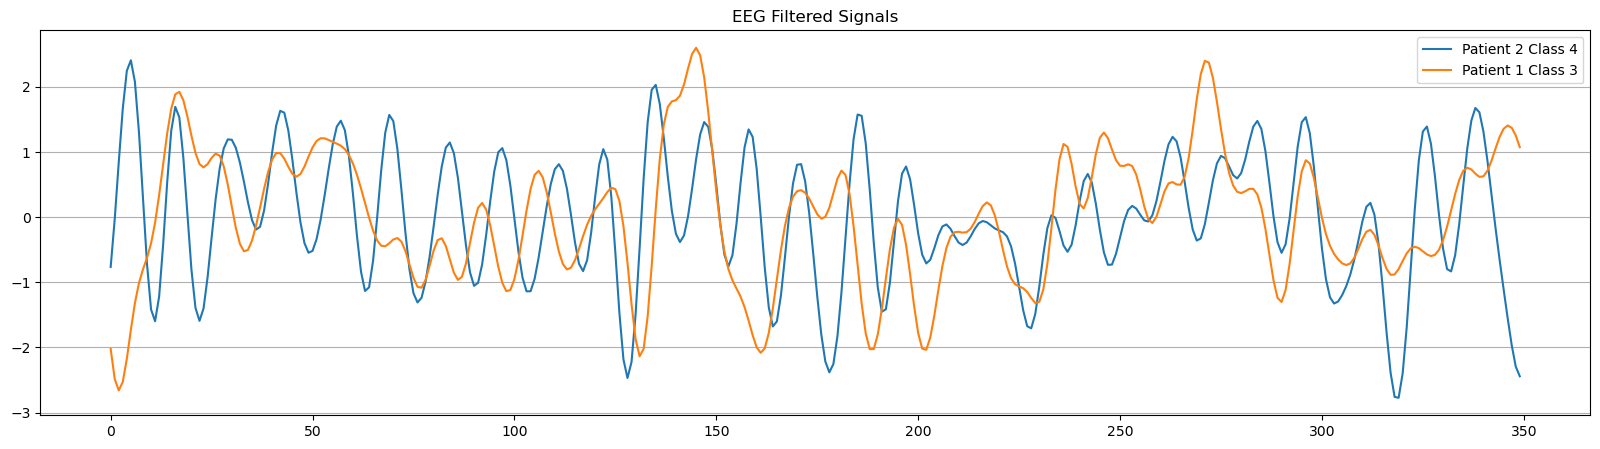

In [15]:
# Plotting the filtered signals for the first sample of each class
plt.figure(figsize=(20, 5))
plt.plot(extended_x[y == 4][0, :-1], label="Patient 2 Class 4")
plt.plot(extended_x[y == 3][0, :-1], label="Patient 1 Class 3")
plt.title("EEG Filtered Signals")
plt.grid(axis='y')
plt.legend()
plt.show()


# CLASSIFIER LOOPS

{'DecisionTreeClassifier': DecisionTreeClassifier(criterion='entropy', max_depth=3), 'SVC': SVC(C=0.1, gamma=0.001), 'RandomForestClassifier': RandomForestClassifier(bootstrap=False, max_depth=10, n_estimators=40)}


/opt/anaconda3/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


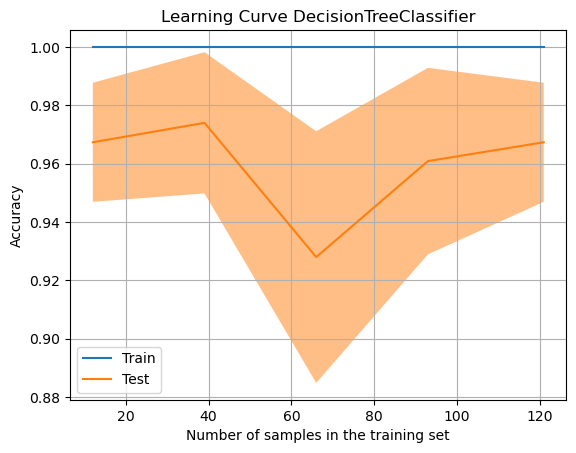

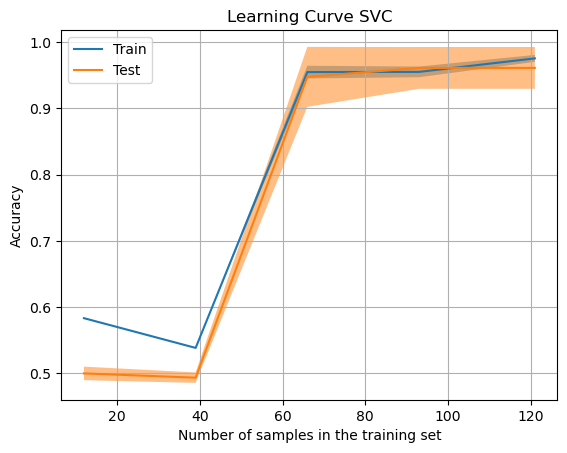

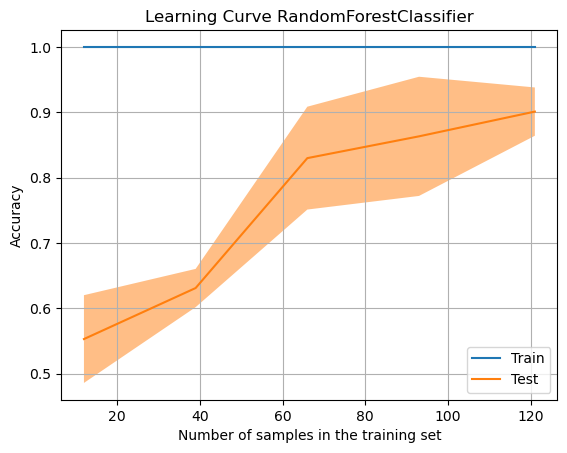

In [16]:
# Training loop
best_models = train_models(models, extended_x, y)
print(best_models)

# Learning curves
for model_name, model in best_models.items():
    LearningCurveDisplay.from_estimator(model, extended_x, y, cv=5, scoring='accuracy')
    plt.title(f'Learning Curve {model_name}')
    plt.grid()
    plt.legend()
    plt.show()

# External test dataset scaling and filtering
X_ext, y_ext = data_scaling_ext(external_test_df)
X_ext = np.apply_along_axis(signal_processing, 1, X_ext)

# EXTERNAL TEST

DecisionTreeClassifier
Accuracy: 0.95
Sensitivity: 0.95
Specificity: 0.95



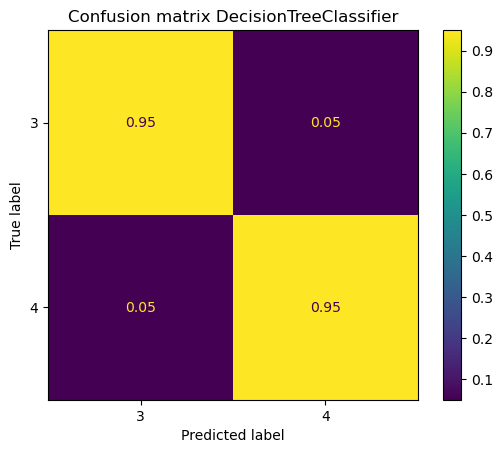

SVC
Accuracy: 0.925
Sensitivity: 0.9
Specificity: 0.95



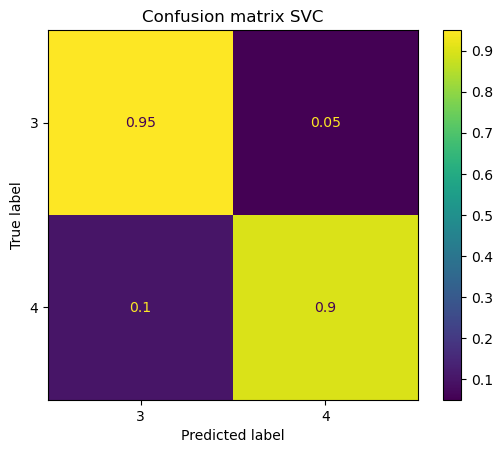

RandomForestClassifier
Accuracy: 0.925
Sensitivity: 0.9
Specificity: 0.95



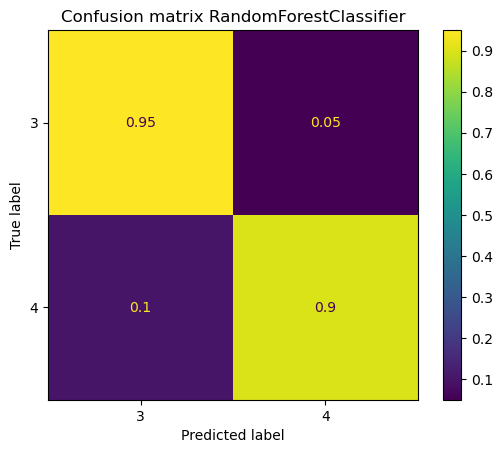

In [17]:
# External test with stats plotting
models_metrics = run_external_test(best_models, X_ext, y_ext)
for model_name, metrics in models_metrics.items():
    print(model_name)
    print("Accuracy:", metrics['accuracy'])
    print("Sensitivity:", metrics['sensitivity'])
    print("Specificity:", metrics['specificity'], end='\n\n')

    ConfusionMatrixDisplay(metrics["confusion_matrix"], display_labels=[3,4]).plot()
    plt.title(f"Confusion matrix {model_name}")
    plt.show()

# Random forest per estimators

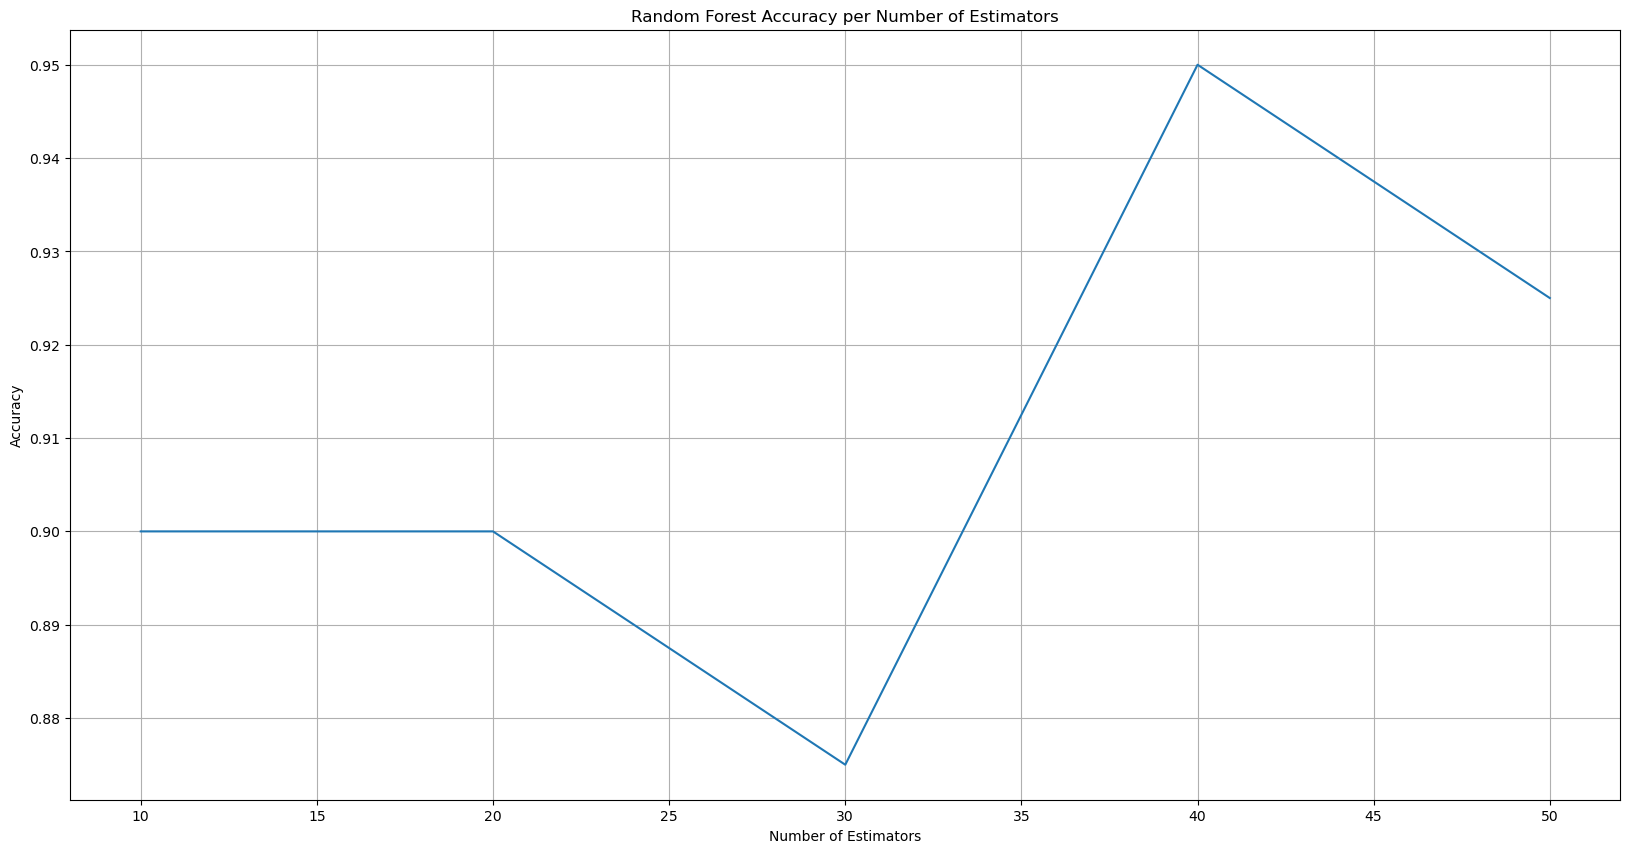

In [18]:
# Plotting the random forest accuracy per number of estimators
n_estimators = [10, 20, 30, 40, 50]
accuracy_plot = []
for n in n_estimators:
    model = RandomForestClassifier(n_estimators=n, criterion='entropy', max_depth=3, max_features='sqrt', min_samples_split=10, bootstrap=True)
    model.fit(extended_x, y)
    y_pred = model.predict(X_ext)
    accuracy = sklearn.metrics.accuracy_score(y_ext, y_pred)
    accuracy_plot.append(accuracy)
plt.figure(figsize=(20, 10))
plt.plot(n_estimators, accuracy_plot)
plt.title("Random Forest Accuracy per Number of Estimators")
plt.xlabel("Number of Estimators")
plt.ylabel("Accuracy")
plt.grid()
plt.show()




In [19]:
# PCA
# Filtered and extended dataset
#extended_x = signal_processing_PCA()

print(extended_x[y == 3][: , -1].mean(axis=0)) 
print(extended_x[y == 4][: , -1].mean(axis=0))  

18.999981000019
40.311648000040314


In [20]:
best_models["DecisionTreeClassifier"].get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': None,
 'splitter': 'best'}

# 20 runs DTC

In [21]:
acc = []
spec = [] 
accuracy = 0
sensitivity = 0
specificity = 0
for i in range (20):
    best_models["DecisionTreeClassifier"].fit(extended_x, y)
    y_pred = best_models["DecisionTreeClassifier"].predict(X_ext)
    accuracy += sklearn.metrics.accuracy_score(y_ext, y_pred)
    sensitivity += sklearn.metrics.recall_score(y_ext, y_pred, pos_label=4)
    specificity += sklearn.metrics.recall_score(y_ext, y_pred, pos_label=3)
accuracy /= 20
sensitivity /= 20
specificity /= 20
acc.append(accuracy)
spec.append(specificity)
print("Accuracy:", accuracy)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)




Accuracy: 0.93875
Sensitivity: 0.9499999999999996
Specificity: 0.9274999999999997


# 20 runs SVM

In [22]:
accuracy = 0
sensitivity = 0
specificity = 0
for i in range (20):
    best_models["SVC"].fit(extended_x, y)
    y_pred = best_models["SVC"].predict(X_ext)
    accuracy += sklearn.metrics.accuracy_score(y_ext, y_pred)
    sensitivity += sklearn.metrics.recall_score(y_ext, y_pred, pos_label=4)
    specificity += sklearn.metrics.recall_score(y_ext, y_pred, pos_label=3)
accuracy /= 20
sensitivity /= 20
specificity /= 20
acc.append(accuracy)
spec.append(specificity)
print("Accuracy:", accuracy)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)


Accuracy: 0.9250000000000004
Sensitivity: 0.9
Specificity: 0.9499999999999996


# 20 runs RFC

In [23]:
accuracy = 0
sensitivity = 0
specificity = 0
for i in range (20):
    best_models["RandomForestClassifier"].fit(extended_x, y)
    y_pred = best_models["RandomForestClassifier"].predict(X_ext)
    accuracy += sklearn.metrics.accuracy_score(y_ext, y_pred)
    sensitivity += sklearn.metrics.recall_score(y_ext, y_pred, pos_label=4)
    specificity += sklearn.metrics.recall_score(y_ext, y_pred, pos_label=3)
accuracy /= 20
sensitivity /= 20
specificity /= 20
acc.append(accuracy)
spec.append(specificity)
print("Accuracy:", accuracy)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)

Accuracy: 0.9337499999999999
Sensitivity: 0.9224999999999997
Specificity: 0.945


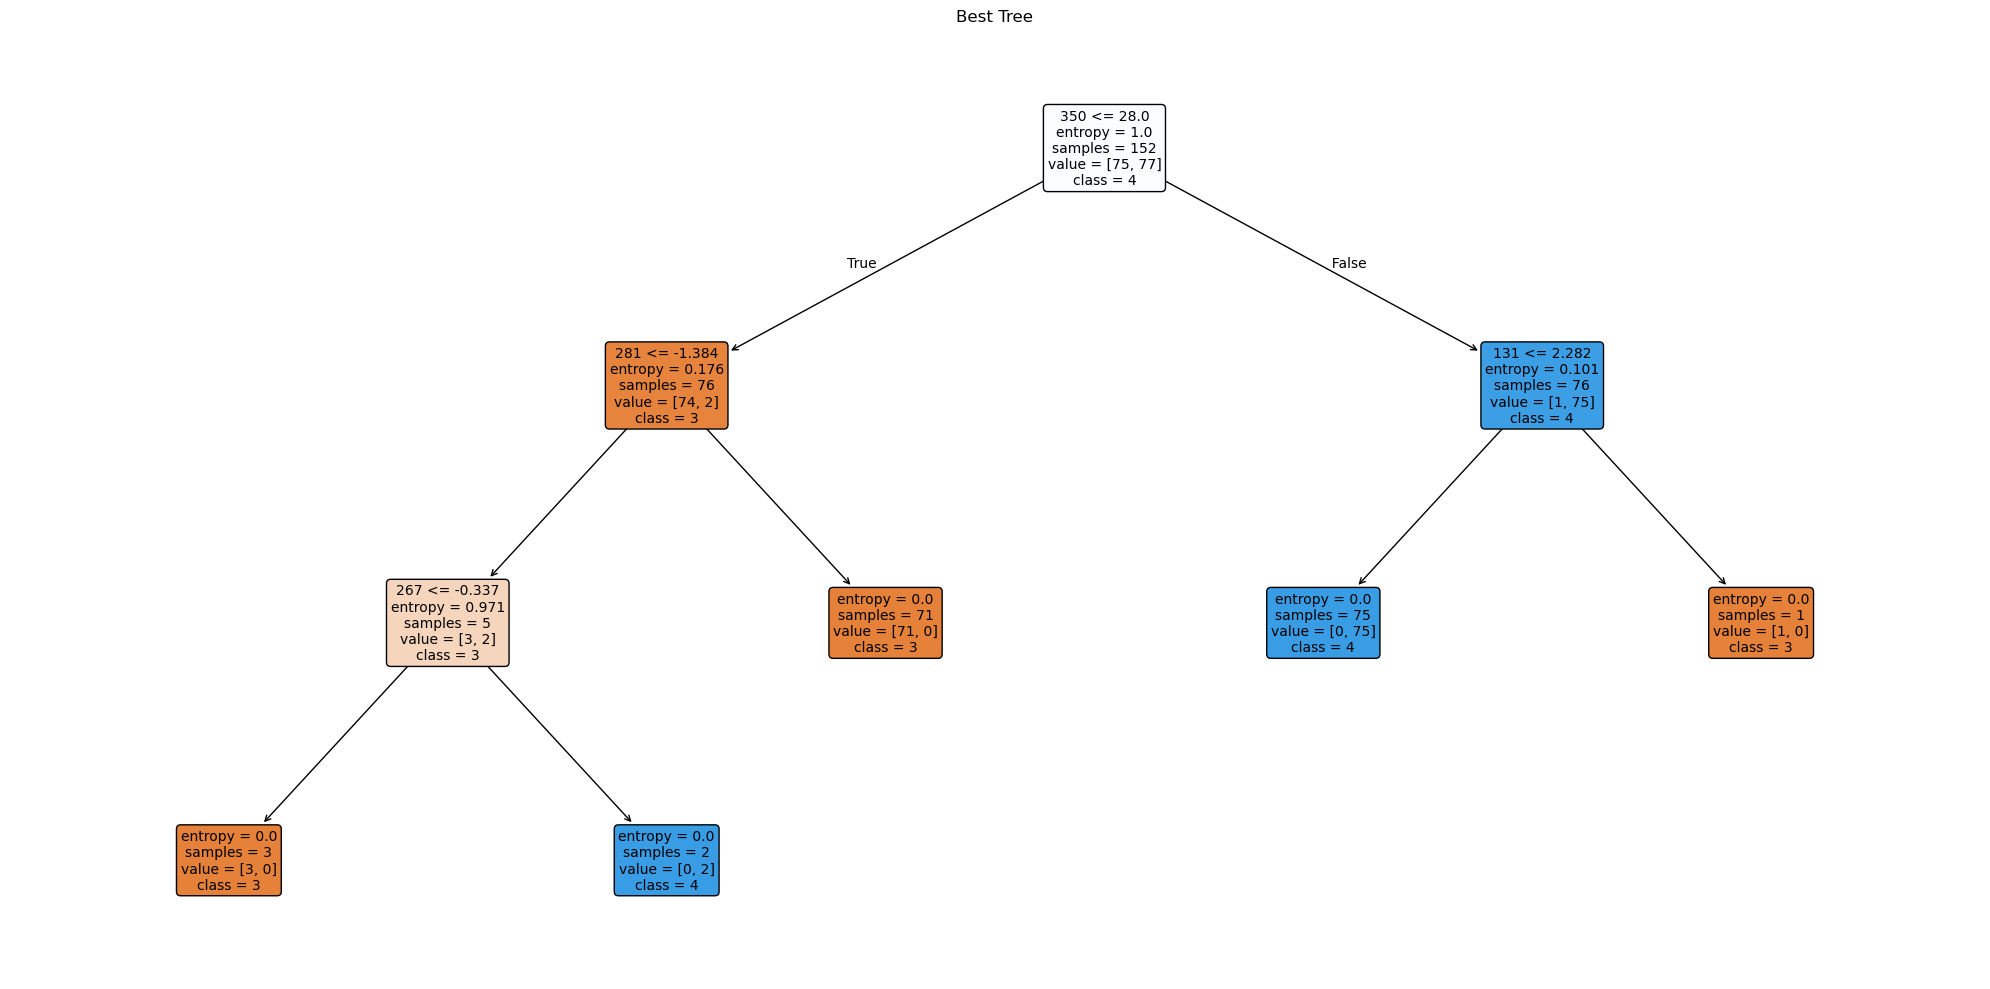

In [24]:
fn = [n for n in range(extended_x.shape[1])]
cn = ["3", "4"]
best_tree = best_models["DecisionTreeClassifier"]
plt.figure(figsize=(20, 10))
tree.plot_tree(best_tree, feature_names=fn, class_names=cn, filled=True, rounded=True, fontsize=10)
plt.title("Best Tree")
plt.tight_layout()
plt.show()

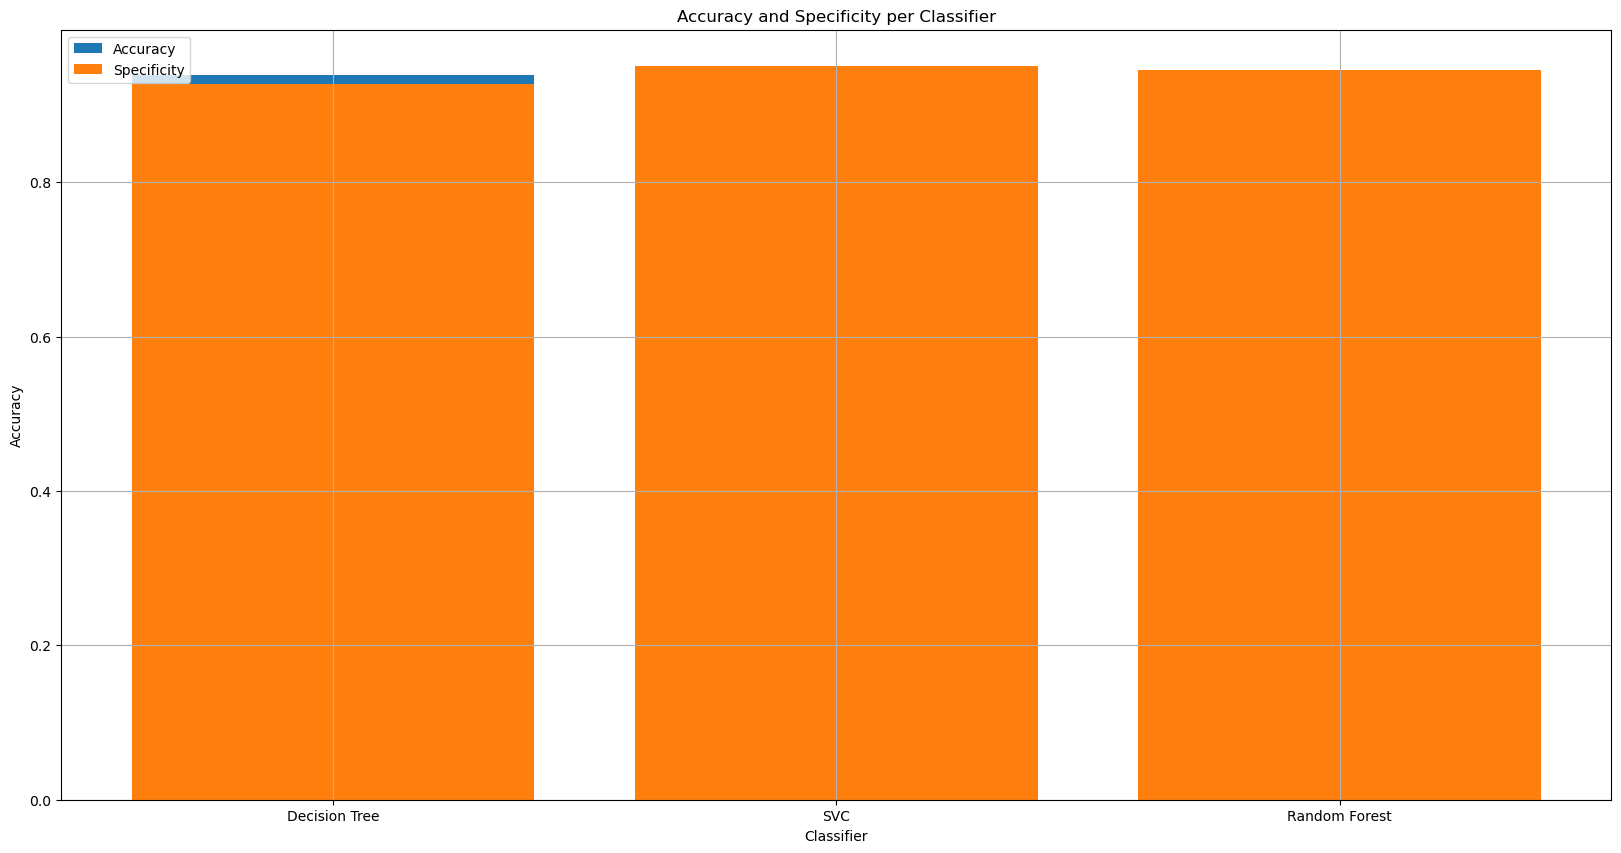

In [25]:
# Plotting each accuracy and specifity in a barplot for each classifier
plt.figure(figsize=(20, 10))
plt.bar(["Decision Tree", "SVC", "Random Forest"], acc, label="Accuracy")
plt.bar(["Decision Tree", "SVC", "Random Forest"], spec, label="Specificity")
plt.title("Accuracy and Specificity per Classifier")
plt.xlabel("Classifier")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()


In [26]:
print(np.where(best_models['DecisionTreeClassifier'].feature_importances_>0))
best_models['DecisionTreeClassifier'].feature_importances_[np.where(best_models['DecisionTreeClassifier'].feature_importances_>0)]

(array([131, 267, 281, 350]),)


array([0.05053979, 0.03194315, 0.05585032, 0.86166673])